For this analysis we will look at respective household income extremes in republican vs democratic districts. To do so, we will leverage two data sources that we will need to combine together. 

First, we will use the American Community Survey 2021 dataset available from census.gov. The data is available via API from here: https://www.census.gov/data/developers/data-sets/acs-1year.html. This data is commonly referenced when people are looking for demographic breakdowns of the American population. This data refers back to the 116th congressional district. 

Second, to get the party affiliation of each congressional district, we will use https://www.house.gov/representatives. Someone has already scraped the house.gov site to turn it into a csv here: http://goodcsv.com/politics/us-house-of-representatives-2020/ for the 116th congressional district.


In [1]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas

First we will read the ACS 2021 dataset and get it into a usable state for our data analysis.

In [2]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here:
# https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State
0,289474,14153,19390,10,Michigan
1,299804,23793,10899,4,Mississippi
2,278057,27728,19574,14,Michigan
3,306685,19036,12208,1,Michigan
4,285554,26481,12412,3,Mississippi


In [3]:

# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

# now let's look at the data again
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State,% of households over $200k,% of households less than $10k
0,289474,14153,19390,10,Michigan,6.698356,4.889213
1,299804,23793,10899,4,Mississippi,3.635375,7.936185
2,278057,27728,19574,14,Michigan,7.039564,9.972056
3,306685,19036,12208,1,Michigan,3.980632,6.207020
4,285554,26481,12412,3,Mississippi,4.346638,9.273552


Now let's get our party affiliation data in a state to merge with the ACS data.

In [4]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

party_df.head(5)

,State,Party,district number
0,Louisiana,R,5
1,North Carolina,D,12
2,Alabama,R,4
3,California,D,31
4,Georgia,R,12


Let's pull some statistics on the two datasets quickly before we join them so we can sanity check that the join worked ok.

In [5]:
party_df['State'].value_counts()

California                  53
Texas                       36
New York                    27
Florida                     27
Pennsylvania                18
Illinois                    18
Ohio                        16
Michigan                    14
Georgia                     14
North Carolina              13
New Jersey                  12
Virginia                    11
Washington                  10
Indiana                      9
Arizona                      9
Tennessee                    9
Massachusetts                9
Minnesota                    8
Missouri                     8
Maryland                     8
Wisconsin                    8
Colorado                     7
Alabama                      7
South Carolina               7
Louisiana                    6
Kentucky                     6
Oklahoma                     5
Oregon                       5
Connecticut                  5
Nevada                       4
Kansas                       4
Arkansas                     4
Iowa    

In [6]:
acs_df['State'].value_counts()

California              53
Texas                   36
Florida                 27
New York                27
Illinois                18
Pennsylvania            18
Ohio                    16
Georgia                 14
Michigan                14
North Carolina          13
New Jersey              12
Virginia                11
Washington              10
Indiana                  9
Massachusetts            9
Arizona                  9
Tennessee                9
Missouri                 8
Wisconsin                8
Minnesota                8
Maryland                 8
South Carolina           7
Alabama                  7
Colorado                 7
Kentucky                 6
Louisiana                6
Connecticut              5
Oklahoma                 5
Oregon                   5
Iowa                     4
Kansas                   4
Arkansas                 4
Mississippi              4
Nevada                   4
Utah                     4
New Mexico               3
West Virginia            3
N

So the ACS dataset has stats for DC and Puerto Rico. The party datset has other terratories like the Virgin Islands. The state counts look right though. Let's go ahead and merge.

In [7]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [8]:
merged_df.describe()

,Total Households,Less than $10k,$200k+,district number,% of households over $200k,% of households less than $10k
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,292471.643678,17605.977011,28522.944828,10.158621,9.721602,6.050237
std,33670.787672,6047.931263,18902.411362,10.656779,6.417955,2.106075
min,183319.000000,6021.000000,5296.000000,0.000000,2.025905,2.208934
25%,273747.000000,13416.000000,14916.000000,3.000000,5.184740,4.653305
50%,292311.000000,16617.000000,22543.000000,6.000000,7.618205,5.679285
75%,311849.500000,21013.500000,37009.500000,13.000000,12.689262,7.036059
max,448949.000000,44929.000000,111988.000000,53.000000,41.846370,16.858153


There are 435 total rows, which matches up with the number of congress members in the 116th congress. Looks pretty good. Let's do a final check by looking at party counts.

In [9]:
# let's take a look at the party breakdown and sanity check that it looks right
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

Let's do our visualization now. We will do a scatter plot of congressional districts and look at the % of households earning over \$200k on one axis and % of households less than $10k on the other axis. We will color the plot based upon the party affiliation of the districts congress member as of the 116th congress.

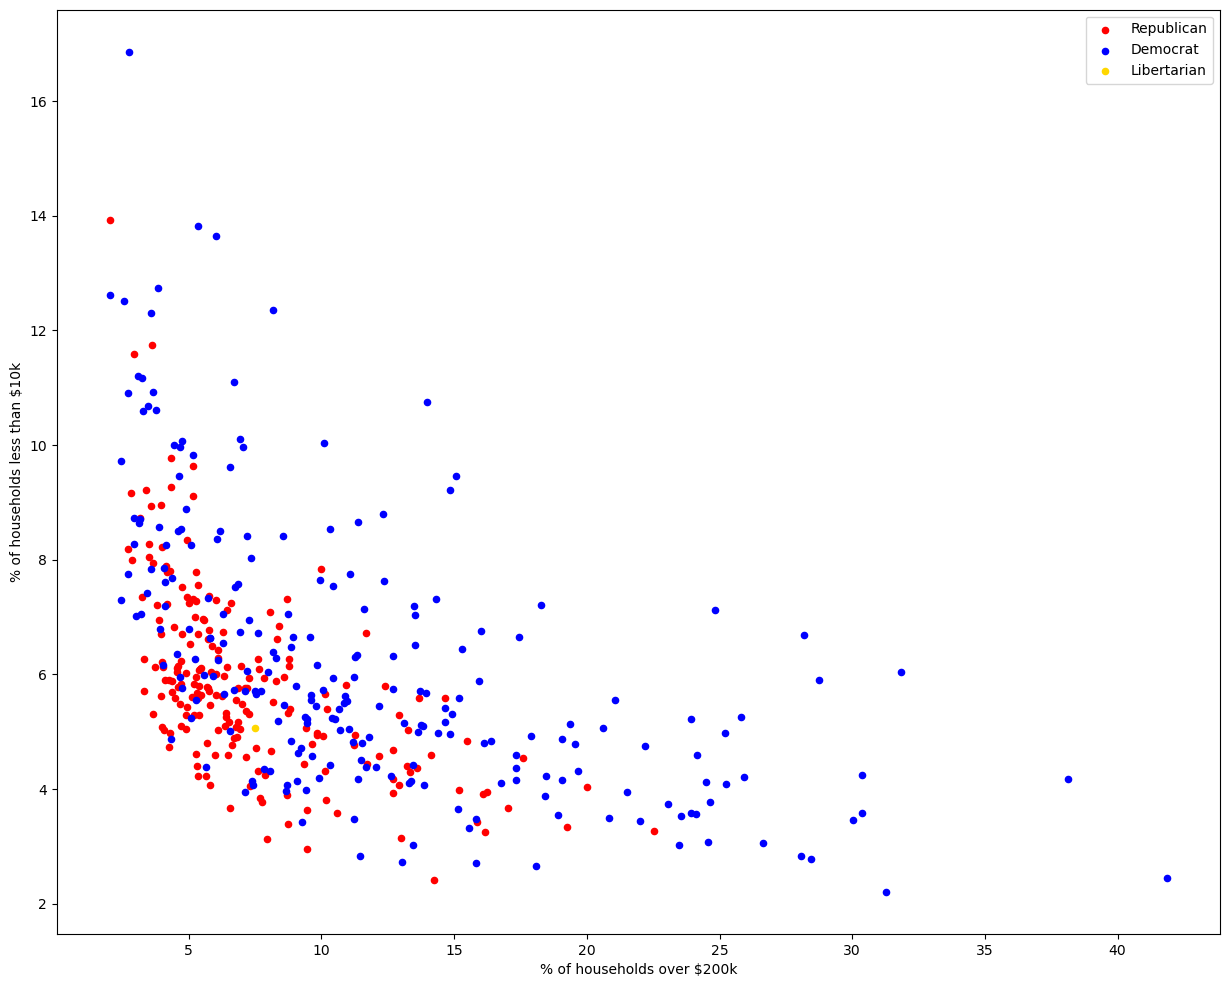

In [10]:
R = merged_df[merged_df['Party'].str.contains('R')]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='% of households less than $10k', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of households less than $10k',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households over $200k', y='% of households less than $10k',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

What conclusions do you draw from this data? In what ways could this be misleading? Is there a better visualization that you would use here? What would be your followup analysis?

In [11]:
merged_df.to_csv("congressional_district_with_parties.csv")

# Our stuff below

In [12]:
#read census data
census_df = pd.read_csv("congressional_district_with_parties.csv")
census_df

,Unnamed: 0,Total Households,Less than $10k,$200k+,district number,State,% of households over $200k,% of households less than $10k,Party
0,0,289474,14153,19390,10,Michigan,6.698356,4.889213,R
1,1,299804,23793,10899,4,Mississippi,3.635375,7.936185,R
2,2,278057,27728,19574,14,Michigan,7.039564,9.972056,D
3,3,306685,19036,12208,1,Michigan,3.980632,6.207020,R
4,4,285554,26481,12412,3,Mississippi,4.346638,9.273552,R
...,...,...,...,...,...,...,...,...,...
430,430,297714,15159,18947,6,Missouri,6.364162,5.091800,R
431,431,320905,19373,14584,7,Missouri,4.544647,6.036989,R
432,432,282817,24427,8871,5,Michigan,3.136657,8.637034,D
433,433,287908,17508,15476,6,Michigan,5.375328,6.081109,R


In [13]:
#import our marriage dataset
marriage = pd.read_excel("/Users/conniechou/Library/CloudStorage/OneDrive-Personal/Connie/Homework/GSB 521 Pierce /Cloud-Computing-Projects/project1/marriage-rates.xlsx")

#clean marriage data by dropping NA values
marriage = marriage.dropna()
marriage.head()

,State,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,2006,2005,2004,2003,2002,2001,2000,1999,1995,1990
1,Alabama,7.577566,7.168500,6.697687,6.760408,7.047340,7.147821,7.351544,7.806776,7.817785,...,9.2,9.2,9.4,9.6,9.9,9.4,10.1,10.8,9.8,10.6
2,Alaska,6.315232,5.696443,6.512245,6.683952,6.914078,7.103441,7.407588,7.508836,7.293928,...,8.2,8.2,8.5,8.1,8.3,8.1,8.9,8.6,9.0,10.2
3,Arizona,5.422112,4.895841,5.302995,5.534434,5.834867,5.930541,5.922469,5.780449,5.401091,...,6.5,6.6,6.7,6.5,6.7,7.6,7.5,8.2,8.8,10.0
4,Arkansas,8.216753,7.776878,8.377284,8.863156,9.456845,9.860962,10.040279,10.112026,9.751052,...,12.4,12.9,13.4,13.4,14.3,14.3,15.4,14.8,14.4,15.3
5,California,5.184868,3.183391,5.723191,6.035132,6.278250,6.463590,6.184957,6.441492,6.460467,...,6.3,6.4,6.4,6.1,6.2,6.5,5.8,6.4,6.3,7.9


In [14]:
#only keep 2021 column and drop district of columbia
marriage_2021 = marriage[["State", 2021]]
marriage_2021 = marriage_2021.drop(marriage[marriage["State"] == "District of Columbia"].index)
marriage_2021.head()

,State,2021
1,Alabama,7.577566
2,Alaska,6.315232
3,Arizona,5.422112
4,Arkansas,8.216753
5,California,5.184868


In [15]:
#merge the two datasets together
my_merge = pd.merge(census_df, marriage_2021, on=["State"])
my_merge = my_merge.rename(columns= {2021: "Marriage Rate"})
my_merge

,Unnamed: 0,Total Households,Less than $10k,$200k+,district number,State,% of households over $200k,% of households less than $10k,Party,Marriage Rate
0,0,289474,14153,19390,10,Michigan,6.698356,4.889213,R,5.161972
1,2,278057,27728,19574,14,Michigan,7.039564,9.972056,D,5.161972
2,3,306685,19036,12208,1,Michigan,3.980632,6.207020,R,5.161972
3,219,289969,14688,21742,3,Michigan,7.498043,5.065369,L,5.161972
4,220,283353,16714,12068,4,Michigan,4.258998,5.898649,R,5.161972
...,...,...,...,...,...,...,...,...,...,...
430,252,322511,18213,19407,0,North Dakota,6.017469,5.647249,R,5.162927
431,311,270163,10992,23553,0,Vermont,8.718070,4.068655,D,7.379525
432,343,248904,16701,11791,2,West Virginia,4.737168,6.709816,R,6.041081
433,345,227342,26328,6644,3,West Virginia,2.922469,11.580790,R,6.041081


In [16]:
from plotnine import *

In [17]:
#create a group by for each state and their marriage rates
marr_rate = my_merge.groupby(by="State").agg({"Marriage Rate": "mean"}).reset_index()
marr_rate.head()

,State,Marriage Rate
0,Alabama,7.577566
1,Alaska,6.315232
2,Arizona,5.422112
3,Arkansas,8.216753
4,California,5.184868


In [18]:
# group by of percent of households less than $10k
poor = my_merge[['State', "% of households less than $10k"]].groupby("State").mean().reset_index()
poor.head()

,State,% of households less than $10k
0,Alabama,7.802695
1,Alaska,5.390493
2,Arizona,5.760895
3,Arkansas,7.666248
4,California,5.342869


In [19]:
# group by percent of households more than $200k
rich = my_merge[['State', "% of households over $200k"]].groupby("State").mean().reset_index()
rich.head()

,State,% of households over $200k
0,Alabama,5.100286
1,Alaska,10.209686
2,Arizona,7.863975
3,Arkansas,4.599023
4,California,14.922772


In [20]:
#merge all 3 together
marr_st_income = marr_rate.merge(poor, on=["State"]).merge(rich, on=["State"])
marr_st_income.head()

,State,Marriage Rate,% of households less than $10k,% of households over $200k
0,Alabama,7.577566,7.802695,5.100286
1,Alaska,6.315232,5.390493,10.209686
2,Arizona,5.422112,5.760895,7.863975
3,Arkansas,8.216753,7.666248,4.599023
4,California,5.184868,5.342869,14.922772


In [21]:
#read political party for each state dataset
state_pol_party = pd.read_csv("/Users/conniechou/Library/CloudStorage/OneDrive-Personal/Connie/Homework/GSB 521 Pierce /Cloud-Computing-Projects/project1/state-pol-party.csv",
                             header = None)
state_pol_party = state_pol_party.rename(columns={0: "State",
                                          1: "Party"})
#drop district of columbia
state_pol_party = state_pol_party.drop(state_pol_party[state_pol_party["State"] == "District of Columbia"].index)
state_pol_party.head()

,State,Party
0,Alabama,Republican
1,Alaska,Republican
2,Arizona,Democrat
3,Arkansas,Republican
4,California,Democrat


In [22]:
#merge with main dataset
new_merged = marr_st_income.merge(state_pol_party, on=["State"])
new_merged

,State,Marriage Rate,% of households less than $10k,% of households over $200k,Party
0,Alabama,7.577566,7.802695,5.100286,Republican
1,Alaska,6.315232,5.390493,10.209686,Republican
2,Arizona,5.422112,5.760895,7.863975,Democrat
3,Arkansas,8.216753,7.666248,4.599023,Republican
4,California,5.184868,5.342869,14.922772,Democrat
5,Colorado,7.388935,4.766406,11.928292,Democrat
6,Connecticut,5.405762,5.216403,14.656114,Democrat
7,Delaware,4.869522,5.182280,8.346897,Democrat
8,Florida,6.845467,6.402690,7.687770,Republican
9,Georgia,5.519018,6.356331,8.221685,Republican


In [23]:
top10=new_merged.sort_values(by="Marriage Rate", ascending = False).head(10)
top10

,State,Marriage Rate,% of households less than $10k,% of households over $200k,Party
27,Nevada,26.204273,7.384936,7.251225,Republican
10,Hawaii,12.830607,5.426003,13.263050,Democrat
25,Montana,11.024468,5.166511,6.856904,Republican
43,Utah,9.084550,4.333682,9.924820,Republican
3,Arkansas,8.216753,7.666248,4.599023,Republican
41,Tennessee,7.602916,6.612081,6.305438,Republican
0,Alabama,7.577566,7.802695,5.100286,Republican
49,Wyoming,7.392844,6.038400,5.840676,Republican
5,Colorado,7.388935,4.766406,11.928292,Democrat
11,Idaho,7.381677,4.417256,6.535922,Republican


In [24]:
top10['Party'].value_counts()

Republican    8
Democrat      2
Name: Party, dtype: int64

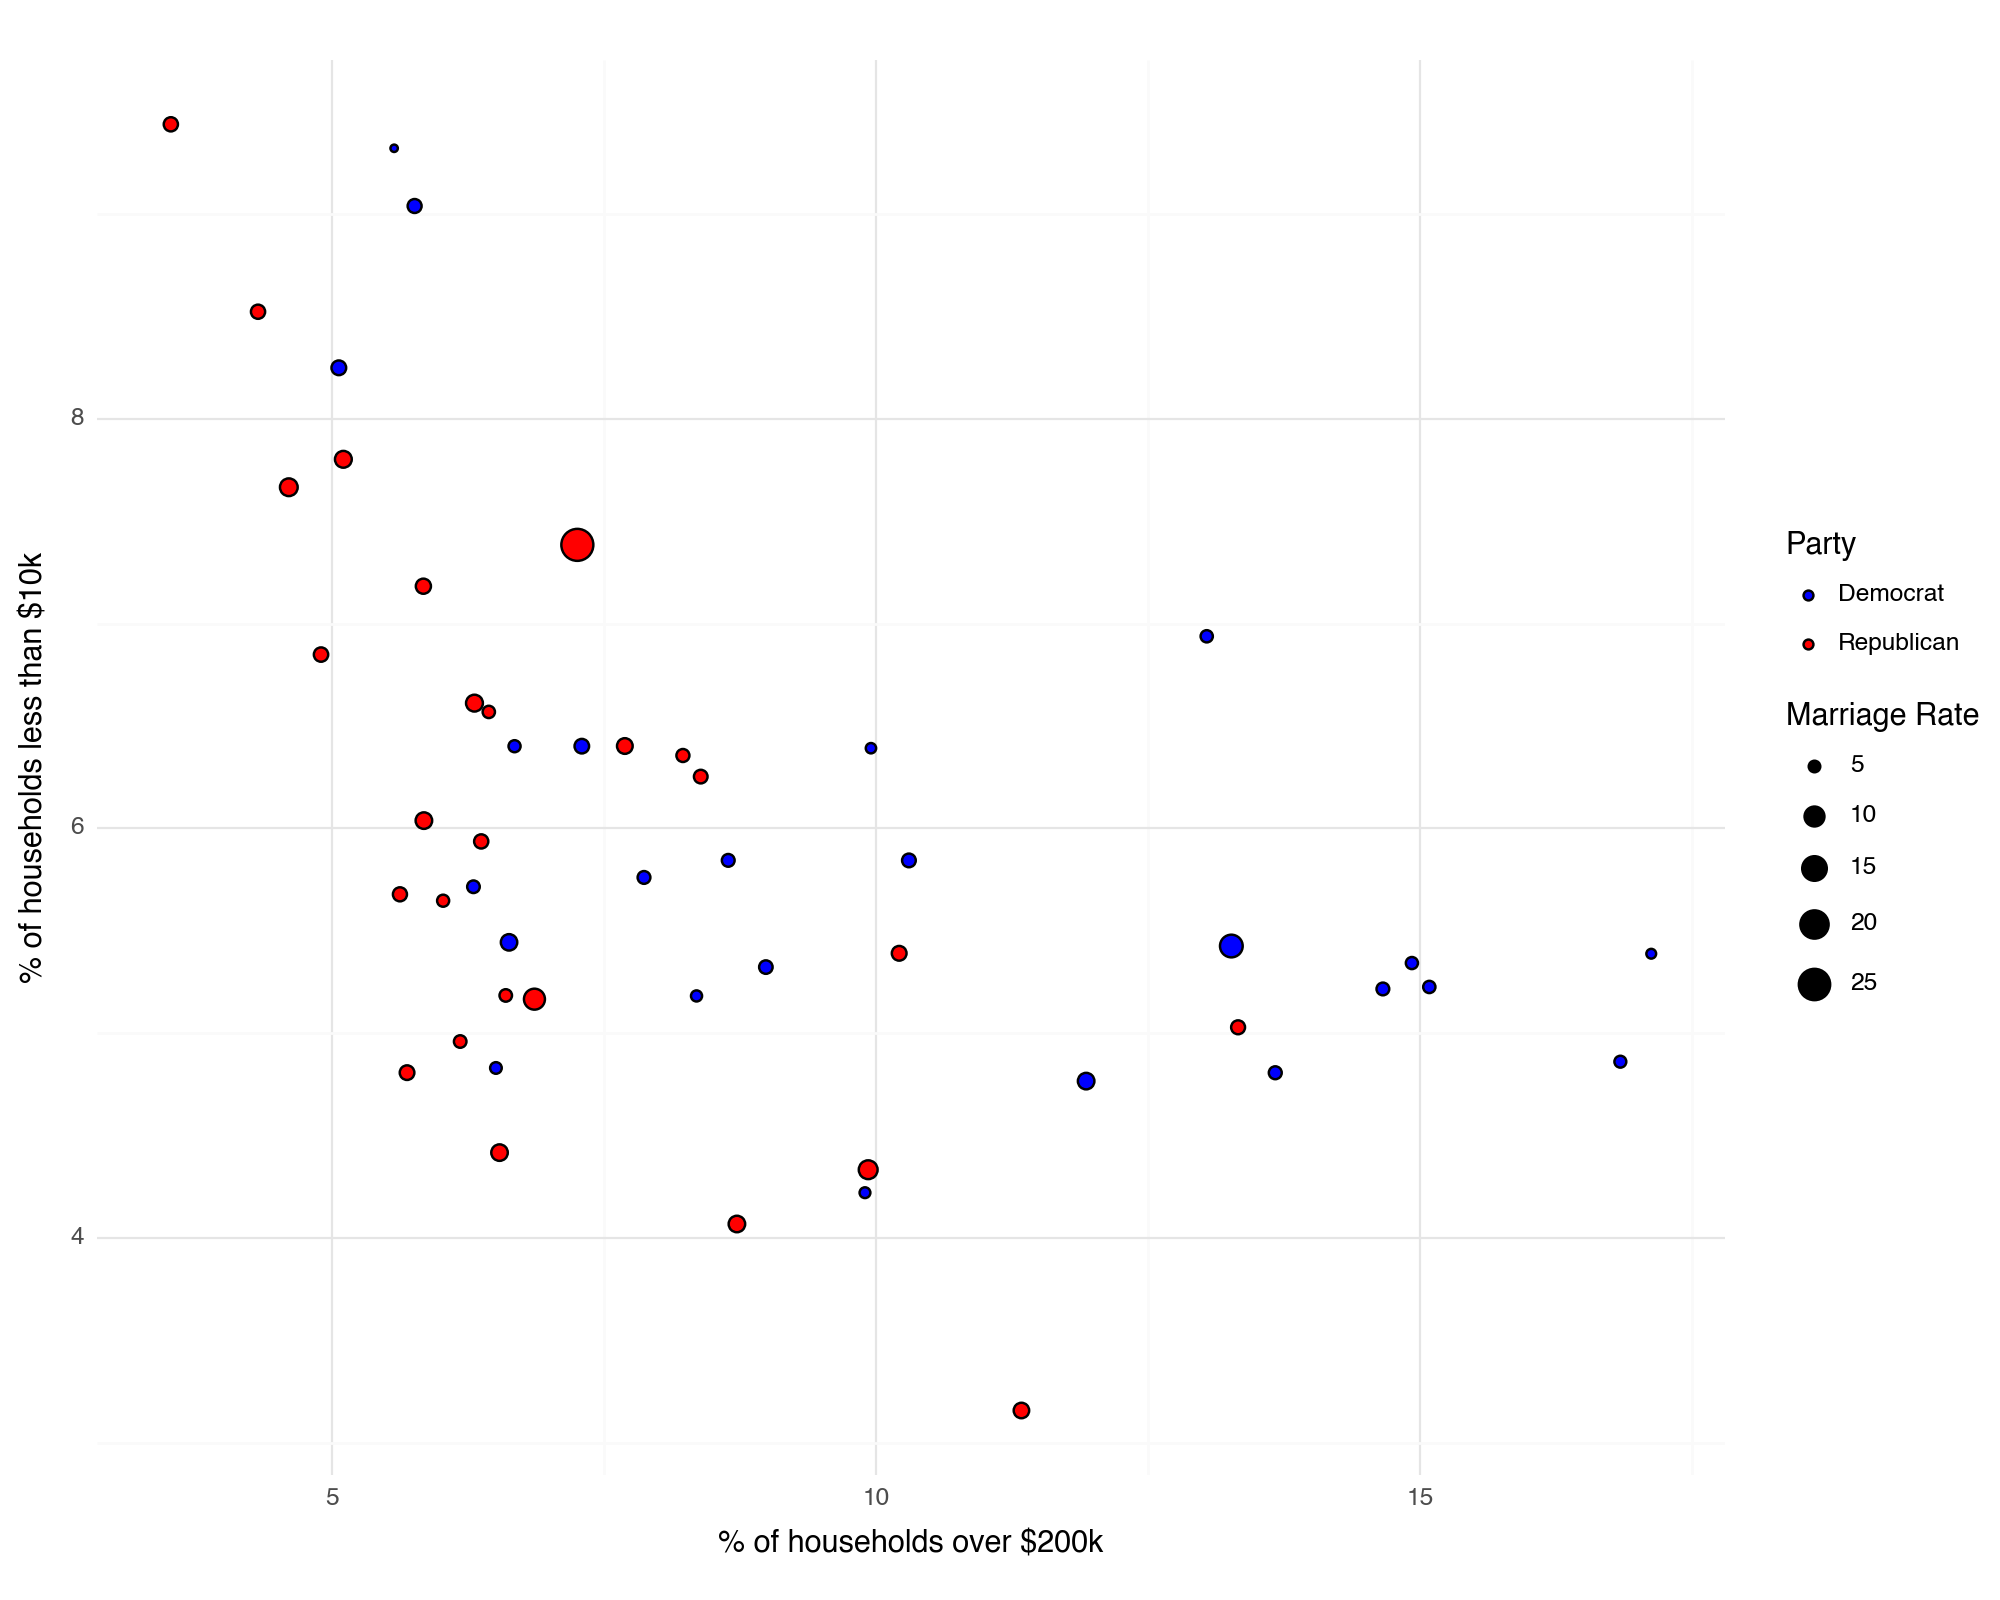

<Figure Size: (1000 x 800)>

In [25]:
#visualize
(ggplot(new_merged, aes(x="% of households over $200k", 
                            y="% of households less than $10k", 
                            size="Marriage Rate",
                       fill="Party"))
 + geom_point()
 + theme_minimal()
+ scale_fill_manual(values = ["blue", "red"])

 # + facet_wrap("Party")
 + theme(figure_size=(10,8))
)

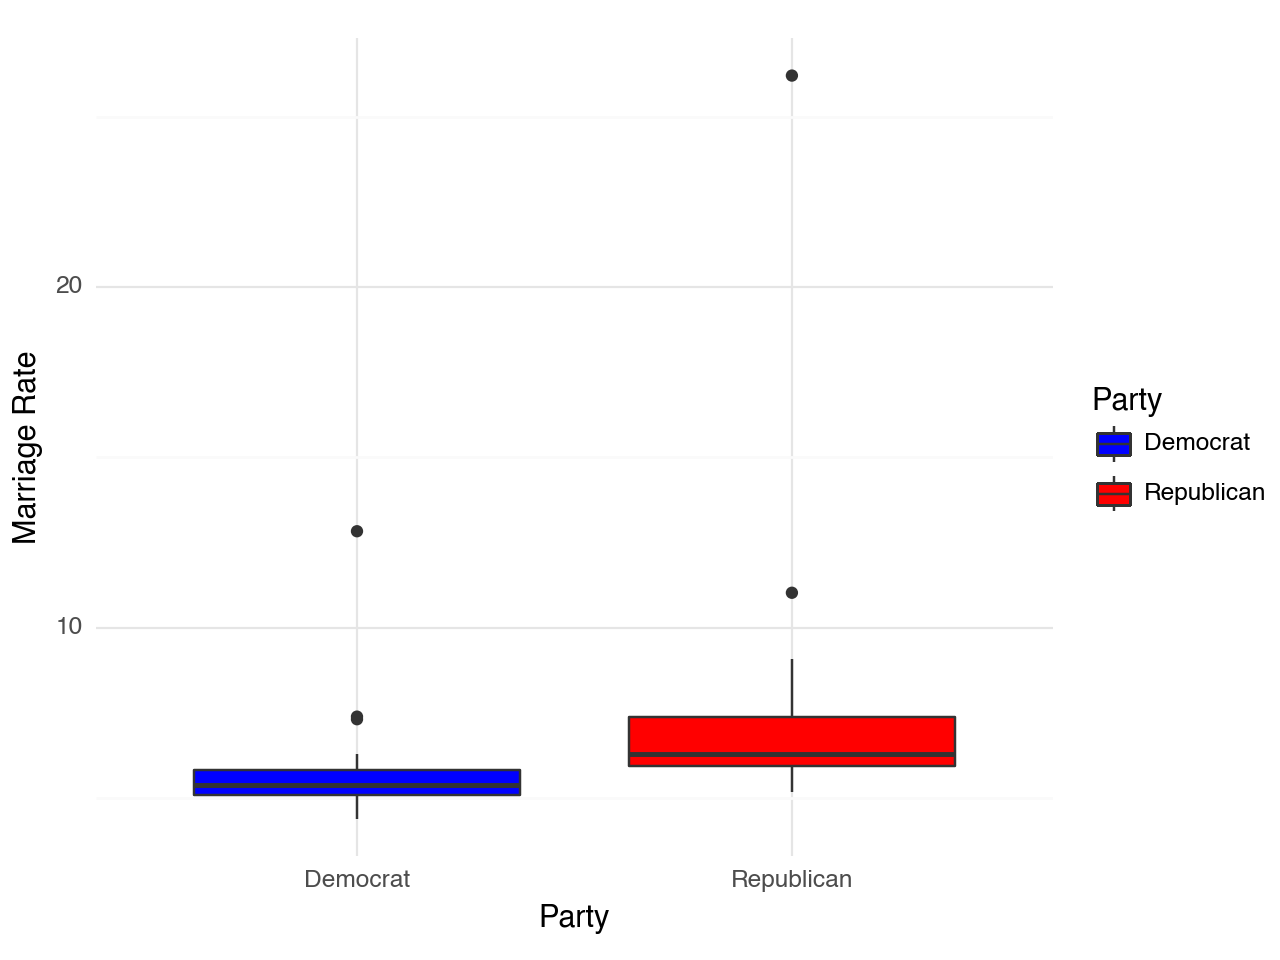

<Figure Size: (640 x 480)>

In [26]:
#boxplot of party and marriage rates
(ggplot(new_merged, aes(x="Party", y="Marriage Rate", fill="Party"))
 + geom_boxplot()
 + scale_fill_manual(values = ["blue", "red"])
 + theme_minimal()
)

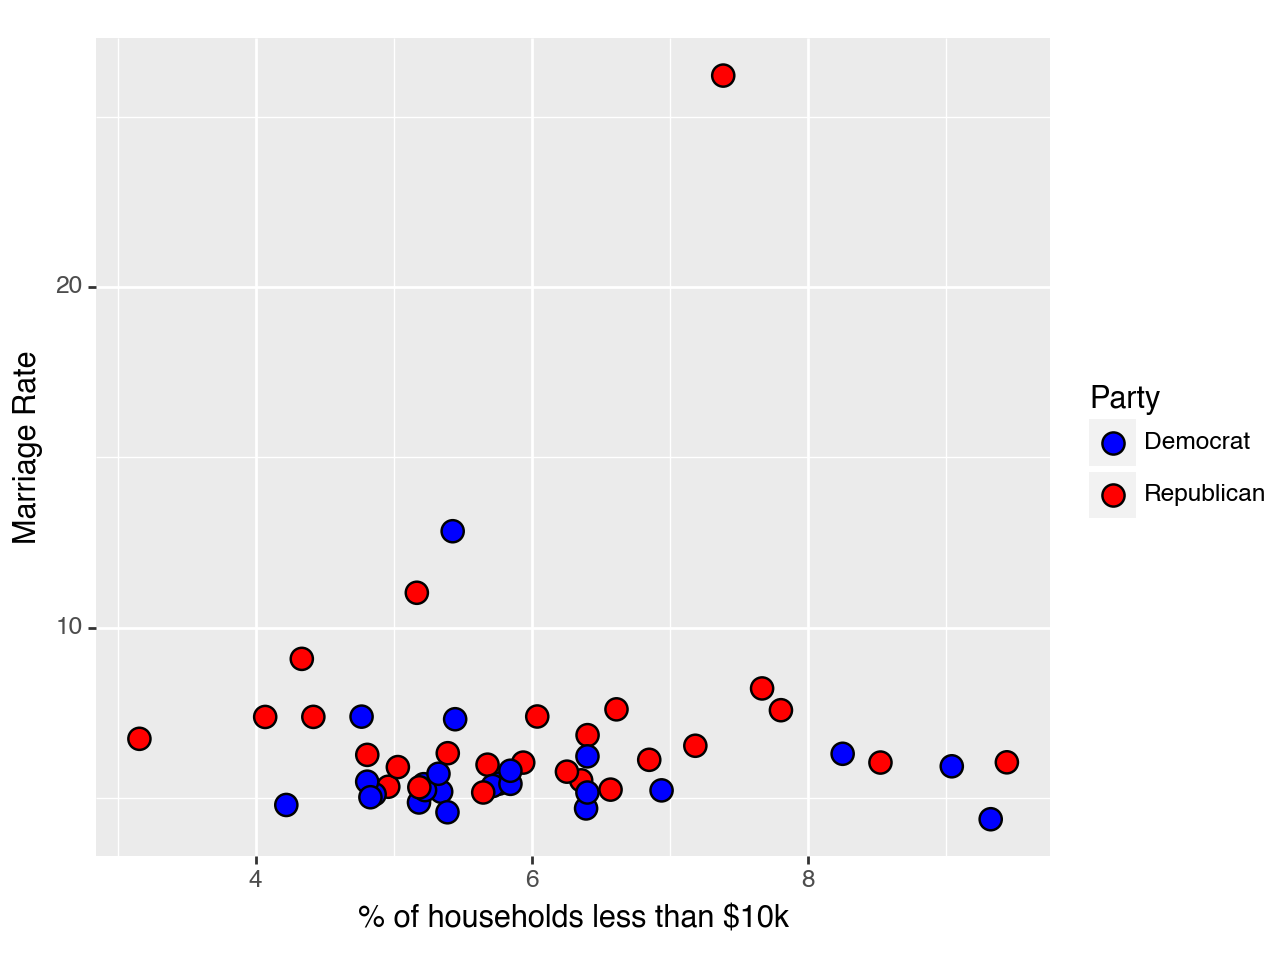

<Figure Size: (640 x 480)>

In [27]:
#scatter plot of <10k income and marriage rates
(ggplot(new_merged, aes(x="% of households less than $10k", y="Marriage Rate", fill="Party"))
 + geom_point(size=4)
  + scale_fill_manual(values = ["blue", "red"])

)

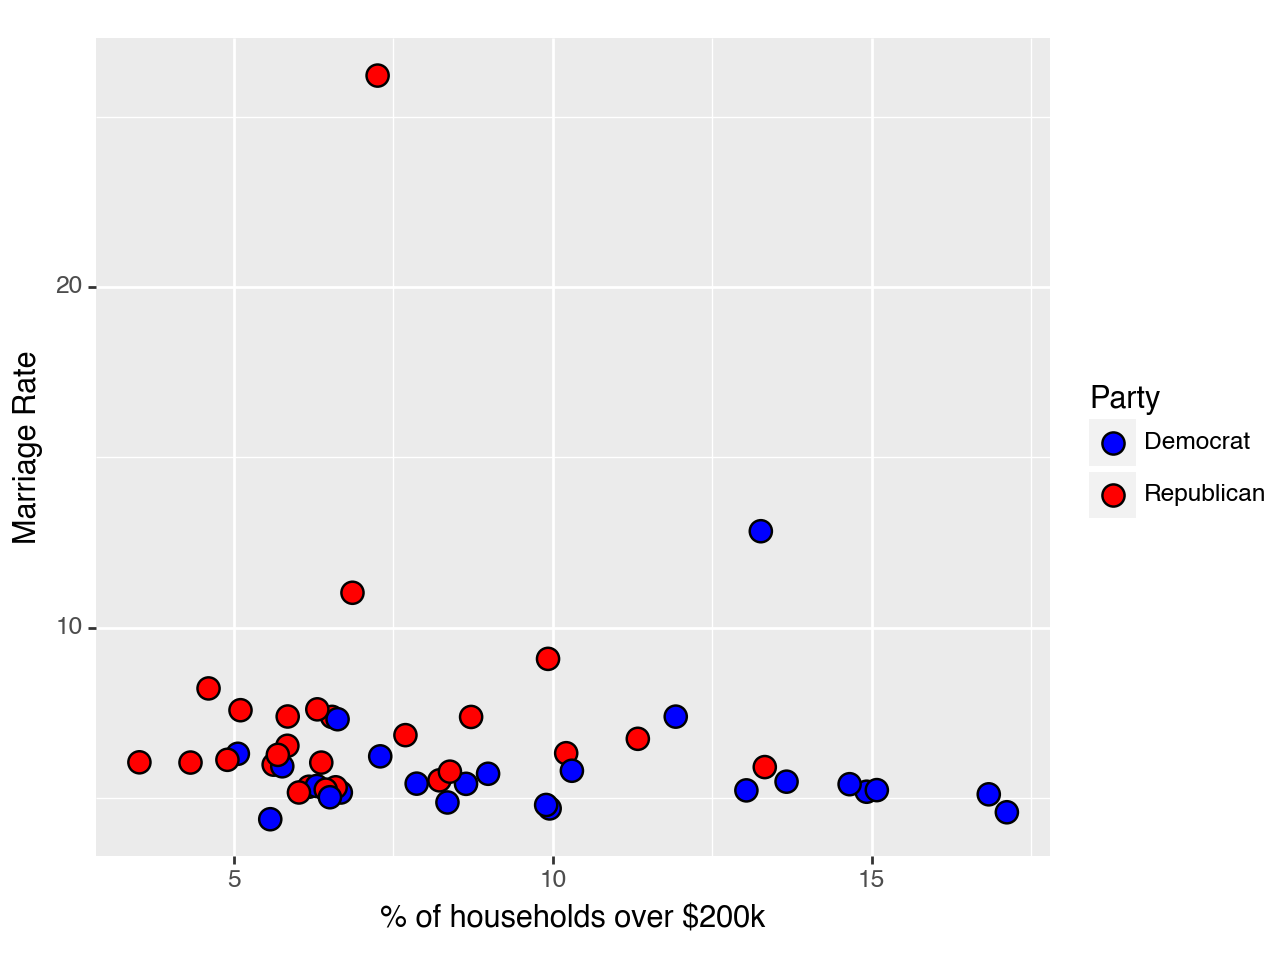

<Figure Size: (640 x 480)>

In [28]:
#scatter plot of >200k income and marriage rates
(ggplot(new_merged, aes(x="% of households over $200k", y="Marriage Rate", fill="Party"))
 + geom_point(size=4)
  + scale_fill_manual(values = ["blue", "red"])

)

In [35]:
new_merged.sort_values(by=["% of households less than $10k", "% of households over $200k"], ascending = [False, False])

,State,Marriage Rate,% of households less than $10k,% of households over $200k,Party
23,Mississippi,6.048207,9.438499,3.514465,Republican
17,Louisiana,4.377767,9.321435,5.567091,Democrat
30,New Mexico,5.931347,9.039594,5.755425,Democrat
47,West Virginia,6.041081,8.523329,4.316001,Republican
16,Kentucky,6.298407,8.249502,5.058676,Democrat
0,Alabama,7.577566,7.802695,5.100286,Republican
3,Arkansas,8.216753,7.666248,4.599023,Republican
27,Nevada,26.204273,7.384936,7.251225,Republican
39,South Carolina,6.533987,7.183018,5.835943,Republican
31,New York,5.224463,6.938461,13.036724,Democrat


In [40]:
#drop nevada and hawaii
no_NV_HI = new_merged[(new_merged["State"] != "Nevada") & (new_merged["State"] != "Hawaii")]
no_NV_HI

,State,Marriage Rate,% of households less than $10k,% of households over $200k,Party
0,Alabama,7.577566,7.802695,5.100286,Republican
1,Alaska,6.315232,5.390493,10.209686,Republican
2,Arizona,5.422112,5.760895,7.863975,Democrat
3,Arkansas,8.216753,7.666248,4.599023,Republican
4,California,5.184868,5.342869,14.922772,Democrat
5,Colorado,7.388935,4.766406,11.928292,Democrat
6,Connecticut,5.405762,5.216403,14.656114,Democrat
7,Delaware,4.869522,5.182280,8.346897,Democrat
8,Florida,6.845467,6.402690,7.687770,Republican
9,Georgia,5.519018,6.356331,8.221685,Republican


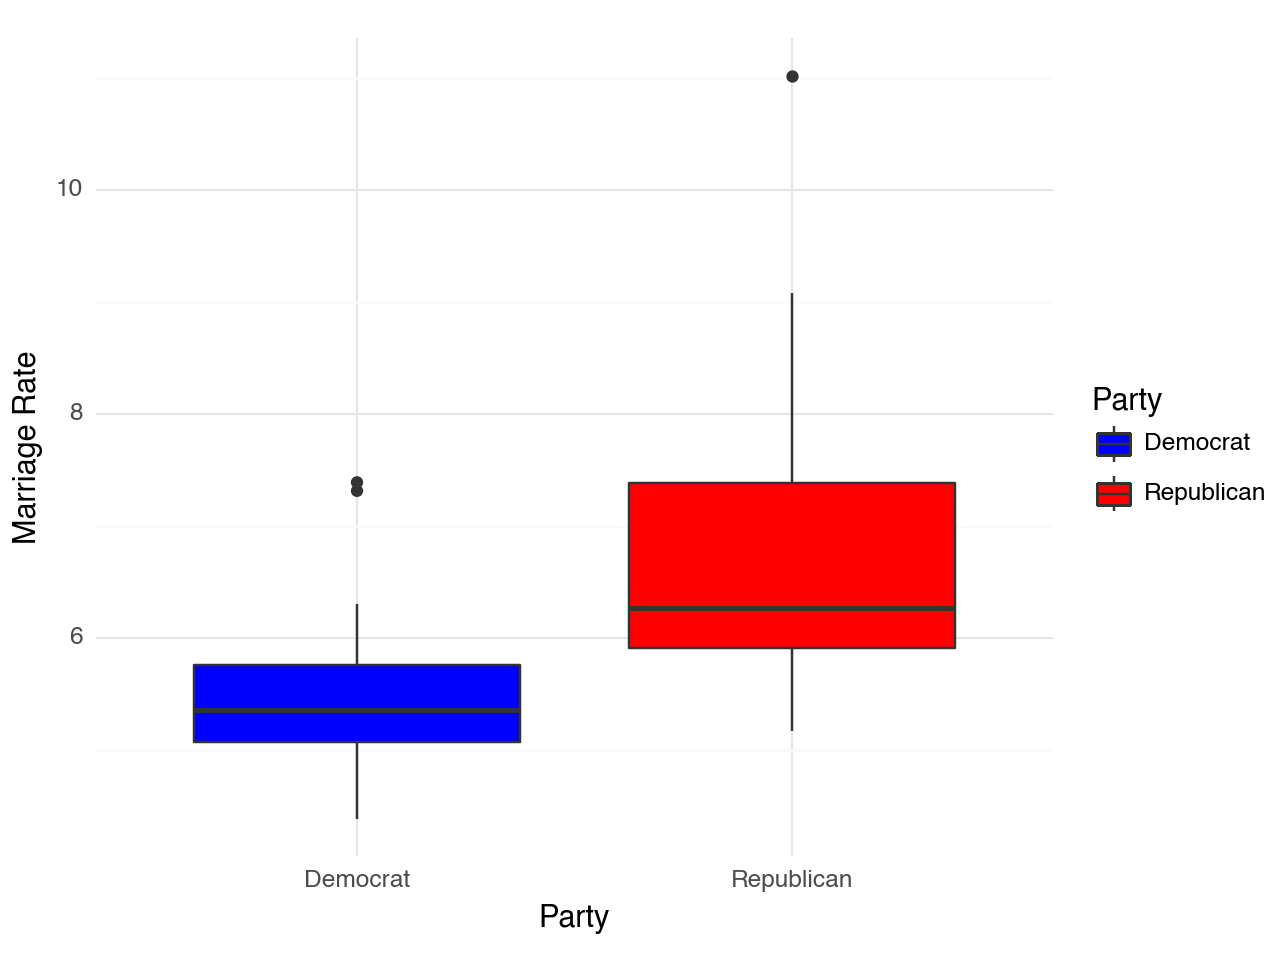

<Figure Size: (640 x 480)>

In [41]:
#boxplot of party and marriage rates
(ggplot(no_NV_HI, aes(x="Party", y="Marriage Rate", fill="Party"))
 + geom_boxplot()
 + scale_fill_manual(values = ["blue", "red"])
 + theme_minimal()
)